In [1]:
student_id = '20224258'
model_name = '20224258'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                    #  'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


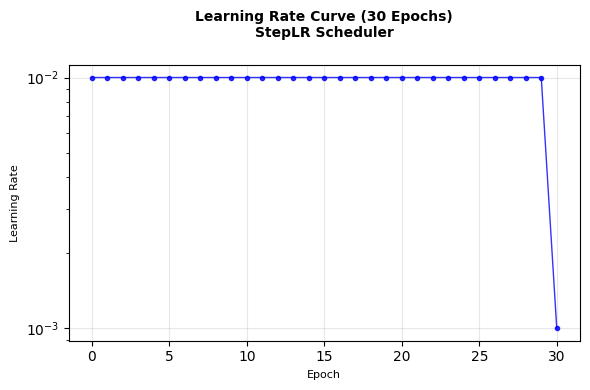


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250617_121328
Dataset: VOC (1/5)
train/val/test: 1747/583/583
submission_20224258 Dataset: VOC) (1/5) Training Start Time: 250617_121328


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

1EP(250617_121355): T_Loss: 1.716236 V_Loss: 1.647942 IoU: 0.0000 Best Epoch: 1 Loss: 1.647942


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

2EP(250617_121421): T_Loss: 1.645436 V_Loss: 1.647726 IoU: 0.0000 Best Epoch: 2 Loss: 1.647726


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

3EP(250617_121447): T_Loss: 1.645449 V_Loss: 1.647648 IoU: 0.0000 Best Epoch: 3 Loss: 1.647648


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

4EP(250617_121513): T_Loss: 1.645284 V_Loss: 1.647611 IoU: 0.0000 Best Epoch: 4 Loss: 1.647611


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

5EP(250617_121539): T_Loss: 1.645296 V_Loss: 1.647590 IoU: 0.0000 Best Epoch: 5 Loss: 1.647590


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [ ]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_20224258']

=== 모델 파라미터 정보 ===
총 파라미터 수: 12,257

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
        ETIS 0.1637 0.2419     0.3596  0.2463
       CVPPP 0.9324 0.9641     0.9642  0.9654
         CFD 0.3206 0.4636     0.6199  0.4203
       CarDD 0.3189 0.4567     0.4162  0.6595

=== 전체 성능 요약 ===
Mean IoU: 0.4339
Mean Dice: 0.5316
Mean Precision: 0.5900
Mean Recall: 0.5729

=== 상세 실험 결과 ===
Dataset Name          Model Name    IoU   Dice  Precision  Recall Total Params
        ETIS submission_20224258 0.1637 0.2419     0.3596  0.2463       12,257
       CVPPP submission_20224258 0.9324 0.9641     0.9642  0.9654       12,257
         CFD submission_20224258 0.3206 0.4636     0.6199  0.4203       12,257
       CarDD submission_20224258 0.3189 0.4567     0.4162  0.6595       12,257


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 29

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565
     LCNet   250616_184055        508258  0.244885
  20224258   250616_225703         29921  0.248373
  20224258   250616_231122         18763  0.220652
  20224258   250617_000718          2968  0.205779
  20224258   250617_002327          5460  0.207724
  20224258   250617_003750          9359  0.225064
  20224258   250617_005022          9359  0.221182
  20224258   250617_010503          1596  0.213568


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250617_120330/core_metrics_250617_120330.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20224258   20224258   250617_120330    0.4339         12257

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250617_120330/detail_metrics_250617_120330.csv

Detail Metrics 내용:
Dataset Name          Model Name    IoU   Dice  Precision  Recall  Total Params
        ETIS submission_20224258 0.1637 0.2419     0.3596  0.2463         12257
       CVPPP submission_20224258 0.9324 0.9641     0.9642  0.9654         12257
         CFD submission_20224258 0.3206 0.4636     0.6199  0.4203         12257
       CarDD submission_20224258 0.3189 0.4567     0.4162  0.6595         12257


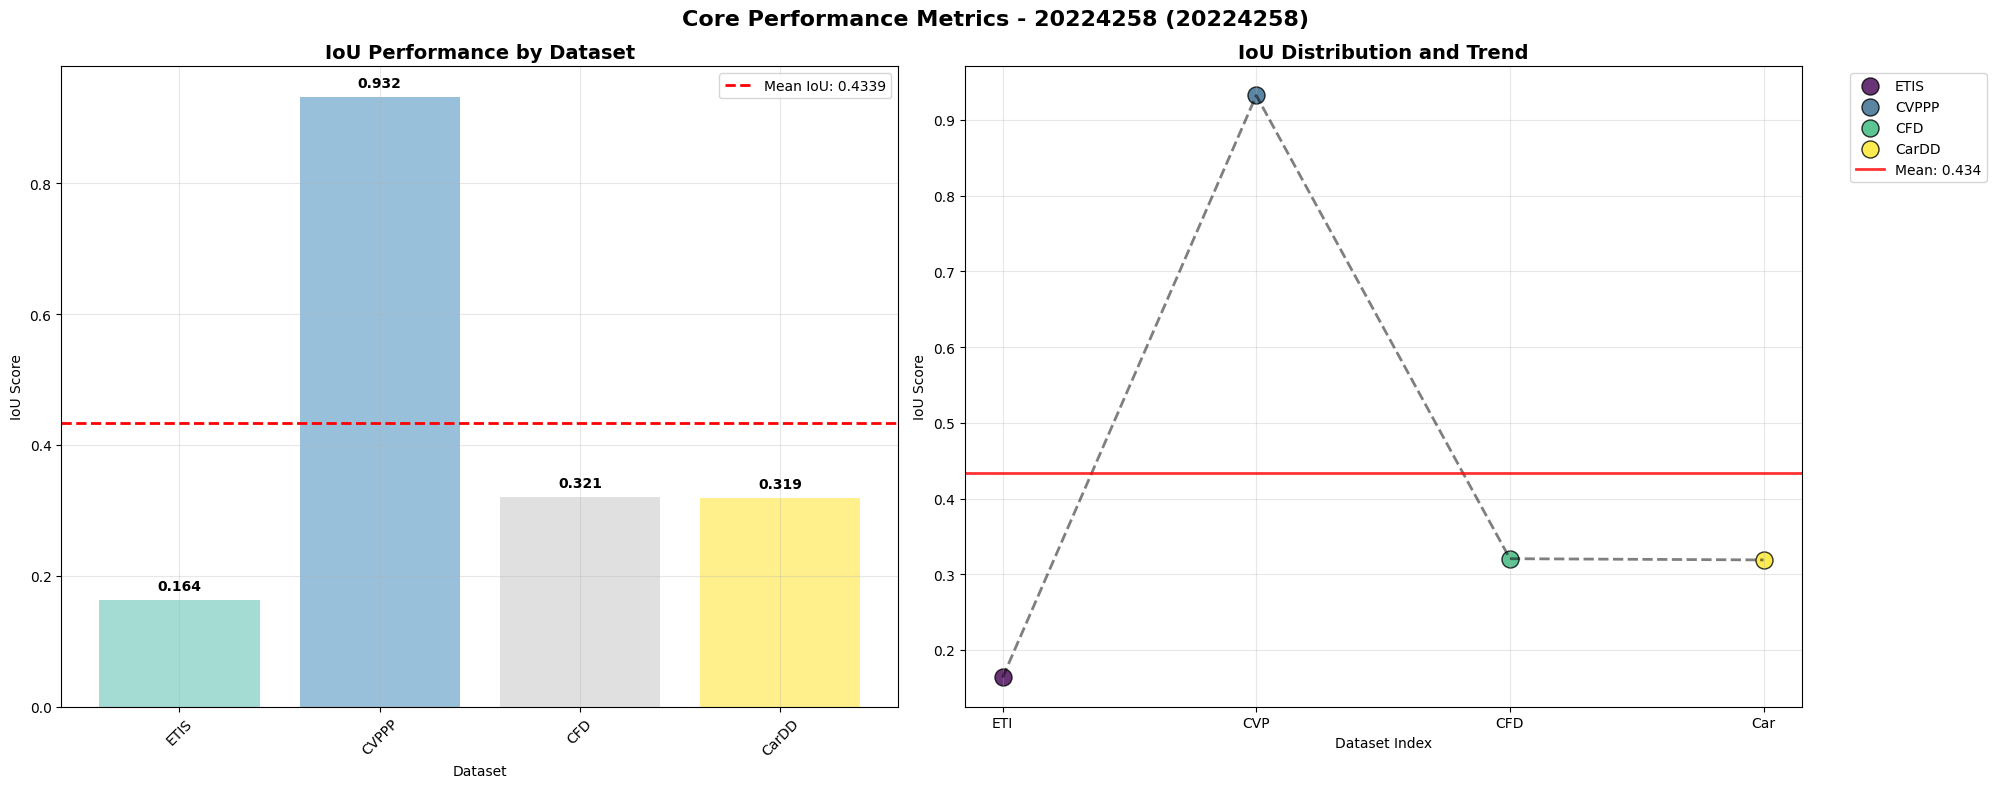

In [ ]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

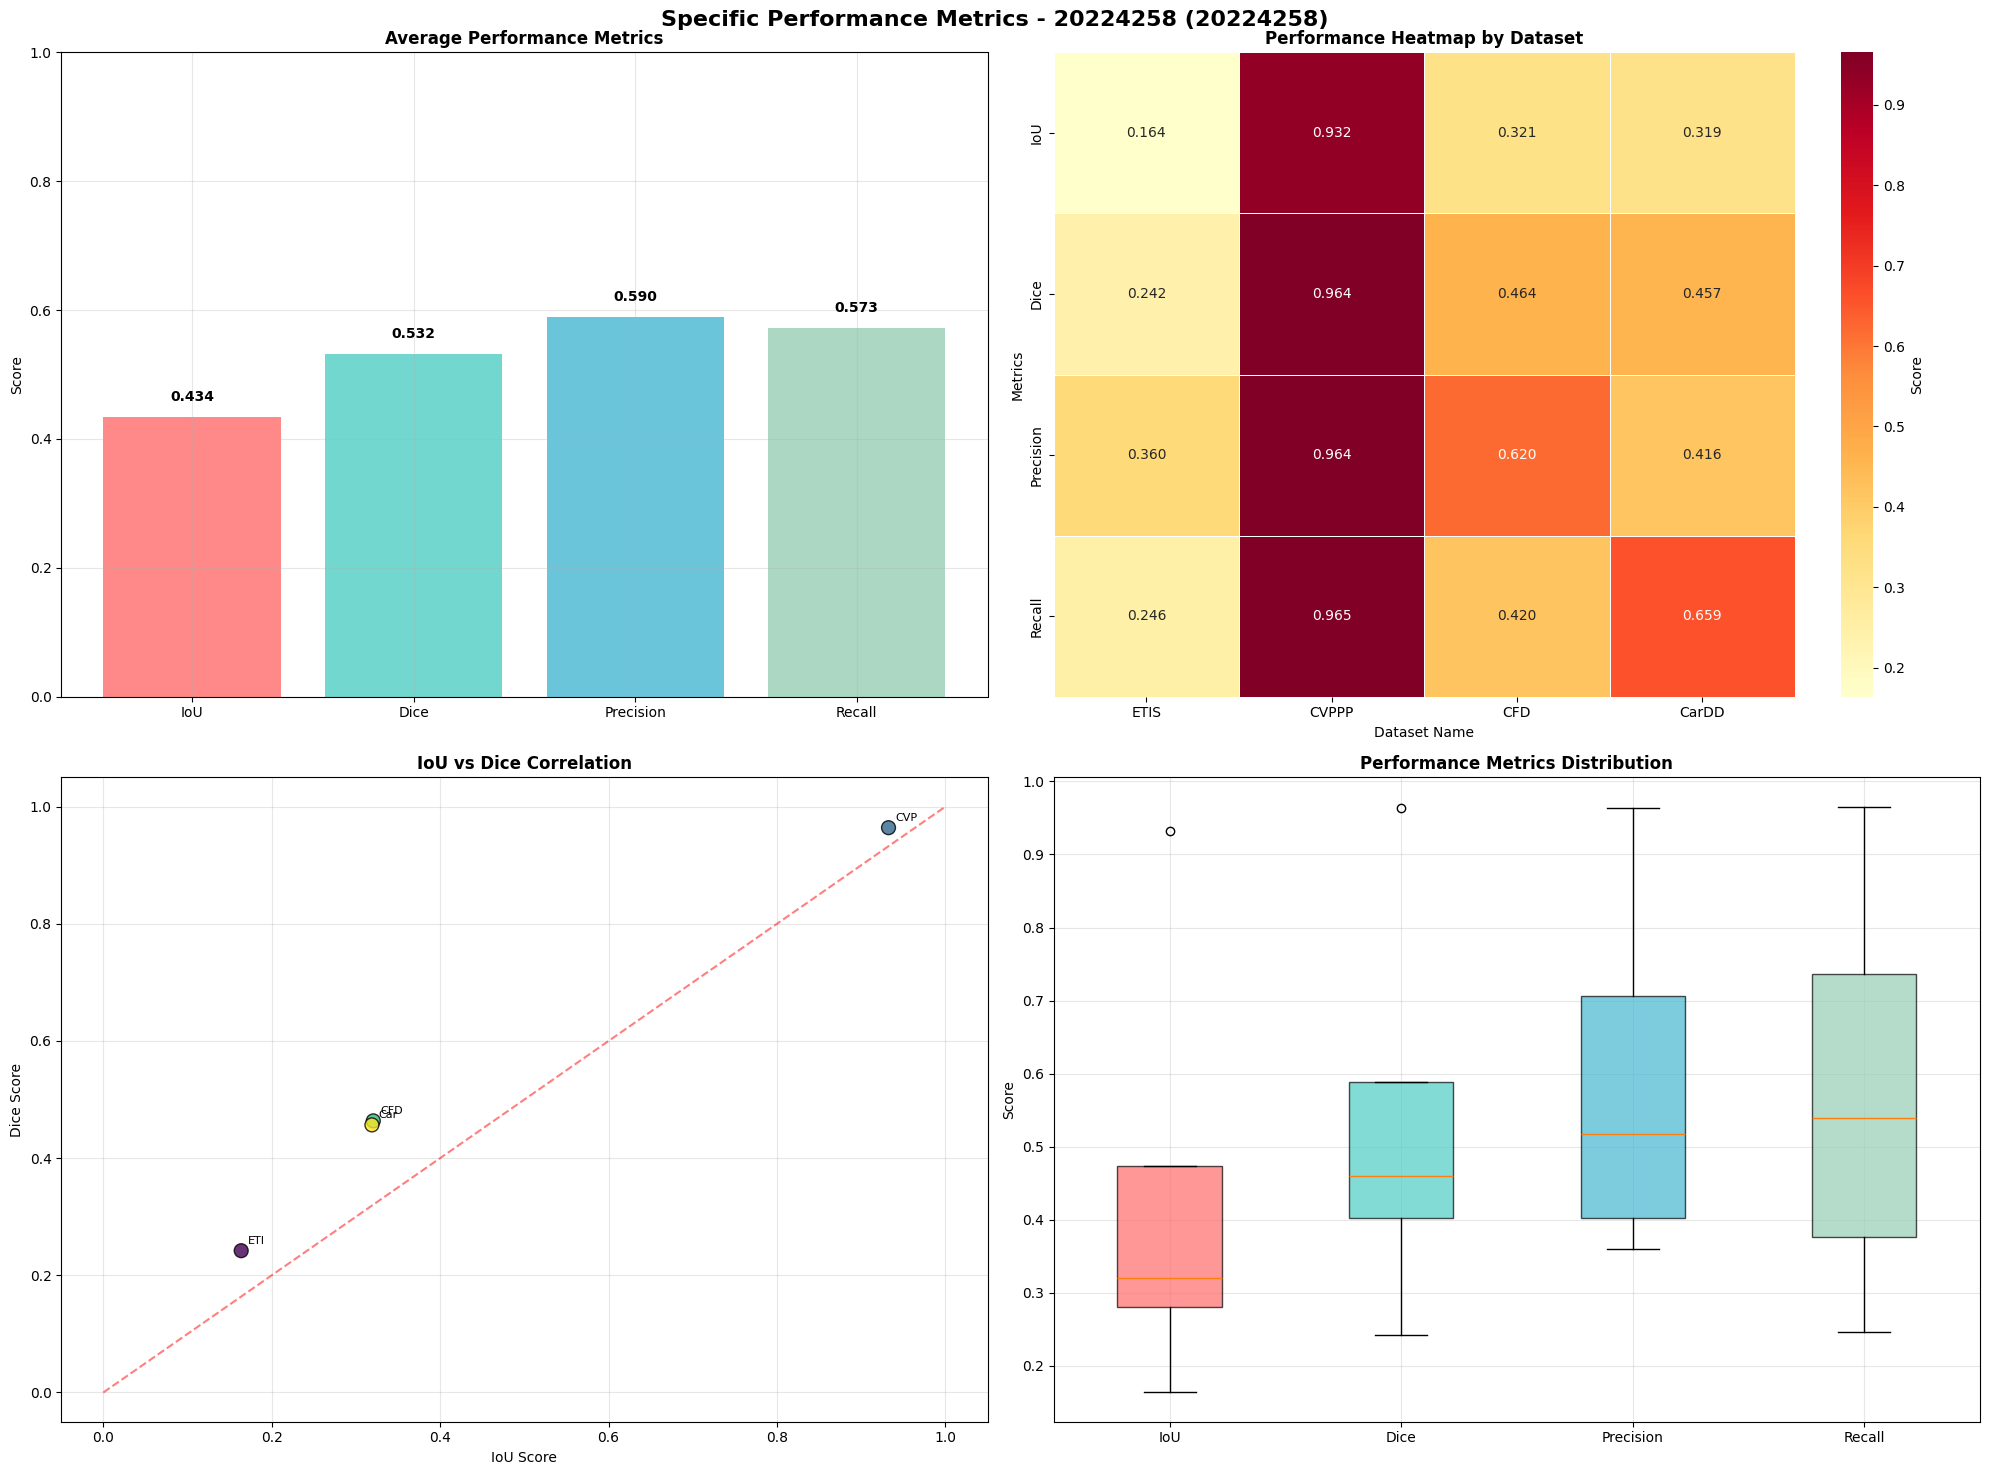

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [ ]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250617_120330/experiment_summary_250617_120330.md
